In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def load_data():
    df = pd.read_csv('nesda_anxiety_file_numbers.csv').astype(np.float)
    df_dtypes = pd.read_csv('nesda_anxiety_data_types.csv')
    y = df.persistance_anxiety
    col_to_remove = ['Pident', 'persistance_anxiety', 'persistance_any', 'cbaiscal', 'pureanxiety', 'Class', 'cduration', 'ctot32mv']
    df.drop(col_to_remove, axis='columns', inplace=True)
    id_remove = df_dtypes.variable_name.isin(col_to_remove)
    df_dtypes = df_dtypes.loc[~id_remove]
    df_dtypes.reset_index(drop=True, inplace=True)
    print(df.shape)
    print(y.value_counts())
    return df, df_dtypes, y

In [3]:
def check_for_missing(df, df_dtypes, missing_value=-9, replace_missing=False, make_plot=True, threshold_to_drop_perc=None):
    n_subj = df.shape[0]
    missing_per_feature = (df == missing_value).sum(axis=0).values
    missing_per_feature_perc = missing_per_feature/n_subj * 100
    
    if make_plot:
        sns.distplot(missing_per_feature_perc, rug=True)
        
    if threshold_to_drop_perc:
        id_drop = missing_per_feature_perc > threshold_to_drop_perc
        assert np.all(df.columns[id_drop] == df_dtypes.variable_name[id_drop]), 'dtypes df and data df do not align'
        print('Dropped variables:')
        print('{}'.format(df.columns[id_drop]))
        print('Percentage missing (value={}): {}'.format(missing_value, missing_per_feature_perc[id_drop]))
        id_keep = ~id_drop
        df = df.loc[:, df.columns[id_keep]]
        df_dtypes = df_dtypes.loc[id_keep, :]
        df_dtypes.reset_index(drop=True, inplace=True)
    
    if replace_missing:
        df.replace(to_replace=missing_value, value=np.nan, inplace=True)
        
    return df, df_dtypes, missing_per_feature_perc

In [4]:
df, df_dtypes, y = load_data()

(994, 723)
0.0    540
1.0    454
Name: persistance_anxiety, dtype: int64


### Investigations into missing values. Explicitly marked as missing are: 
1. -9 - data not collected 
2. -8 - not applicable
3. -7 - could not be calculated

(1) will be replaced by NaN (normal missing value) and variables will be investigated and dropped if they have to many values missing; (2) will be set to 0 (should not play a role for a particular subject) (but see the investigations below) and (3) will be investigated in more detail but set as NaN (i.e. missing) as well

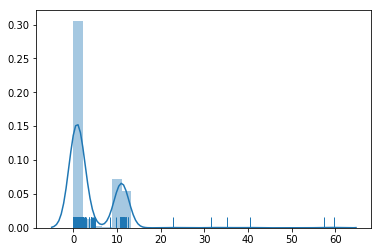

In [5]:
_ = check_for_missing(df, df_dtypes, missing_value=-9)

#### Based on what can be seen in the plot we decided to drop the variables with more than 20% missing values (6 variables)

In [6]:
df, df_dtypes, _ = check_for_missing(df, df_dtypes, missing_value=-9, make_plot=False, replace_missing=True, threshold_to_drop_perc=20)

Dropped variables:
Index(['IA235_10', 'IA235_11', 'IVA413_01', 'IVA491_01', 'IVA491_02',
       'IVA491_03'],
      dtype='object')
Percentage missing (value=-9): [59.75855131 57.34406439 22.73641851 40.44265594 31.58953722 35.11066398]


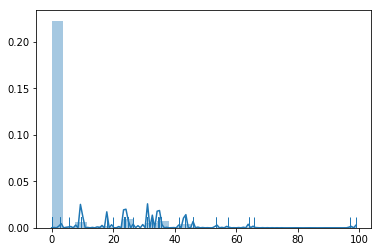

In [8]:
_, _, missing_values_perc = check_for_missing(df, df_dtypes, missing_value=-8)

In [9]:
not_applicable_names_dtypes = df_dtypes.loc[missing_values_perc > 0]
missing_values_perc_true_missing = missing_values_perc[missing_values_perc > 0]
print('Variables with "not applicable" missing values')
for var_type in ['Nominal', 'Ordinal', 'Scale']:
    print(var_type)
    var_name = not_applicable_names_dtypes.loc[not_applicable_names_dtypes.data_type == var_type, 'variable_name'].values
    perc_missing = missing_values_perc_true_missing[not_applicable_names_dtypes.data_type == var_type]
    id_sort = np.argsort(perc_missing)
    
    # I want to know what are the min/max values within any of these variables WHEN NOT APPLICABLE VALUES (AND THE OTHER MISSING CATEGORY) is EXCLUDED
    # I artificially set them to 0, if the min value afterwards is 0 then I know that the variable is POSITIVE without the missing values
    values_per_variable = df[var_name].values
    values_per_variable[(values_per_variable == -8) | (values_per_variable == -7)] = 0
    non_missing_values_min = np.nanmin(values_per_variable, axis=0)
    non_missing_values_max = np.nanmax(values_per_variable, axis=0)
    
    print(var_name[id_sort])
    print('{}/{} variable'.format(var_name.size, not_applicable_names_dtypes.shape[0]))
    print('Percentage missing: {}'.format(perc_missing[id_sort]))
    print('(Percentage missing min/max: {}/{})'.format(perc_missing.min(), perc_missing.max()))
    print('Min/Max values of the variables:')
    print('Min: {}'.format(non_missing_values_min[id_sort]))
    print('Max: {}'.format(non_missing_values_max[id_sort]))
    print()

Variables with "not applicable" missing values
Nominal
['IA301_01' 'IA301_18' 'IA301_17' 'IA301_16' 'IA301_15' 'IA301_14'
 'IA301_13' 'IA301_11' 'IA301_10' 'IA301_12' 'IA301_08' 'IA301_07'
 'IA301_06' 'IA301_05' 'IA301_04' 'IA301_03' 'IA301_02' 'IA301_09'
 'IIIA204_11' 'IIIA204_15' 'IIIA204_14' 'IIIA204_13' 'IIIA204_12'
 'IIIA204_10' 'IA303_19' 'IA303_16' 'IA303_18' 'IA303_15' 'IA303_20'
 'IA303_17' 'IIIA111_21' 'IIIA111_16' 'IIIA111_17' 'IIIA111_11'
 'IIIA111_10' 'IIIA111_09' 'IIIA111_08' 'IIIA111_07' 'IIIA111_06'
 'IIIA111_13' 'IIIA111_14' 'IVA351_01' 'IVA351_05' 'IVA351_04'
 'IIIA103_04' 'IIIA111_03']
46/113 variable
Percentage missing: [ 9.65794769  9.65794769  9.65794769  9.65794769  9.65794769  9.65794769
  9.65794769  9.65794769  9.65794769  9.65794769  9.65794769  9.65794769
  9.65794769  9.65794769  9.65794769  9.65794769  9.65794769  9.65794769
 17.90744467 17.90744467 17.90744467 17.90744467 17.90744467 17.90744467
 23.34004024 23.34004024 23.34004024 23.34004024 23.34004024

In [ ]:
# print("Let's see the 'distribution' of values in the nominal 'not applicable' variables")
# not_applicable_nominal = not_applicable_names_dtypes.loc[not_applicable_names_dtypes.data_type == 'Nominal', 'variable_name'].values
# for var_name in not_applicable_nominal:
#     print(df.loc[:, var_name].value_counts())
#     print()

In [ ]:
# print("Let's see the 'distribution' of values in the ordinal 'not applicable' variables")
# not_applicable_ordinal = not_applicable_names_dtypes.loc[not_applicable_names_dtypes.data_type == 'Ordinal', 'variable_name'].values
# for var_name in not_applicable_ordinal:
#     print(df.loc[:, var_name].value_counts())
#     print()

### From all the experiments above the following heuristic in dealing with 'not applicable' missing values is derived:
1. drop all variables with more than 50% 'not applicable' values 
2. replace NOMINALLY scaled 'not applicable' values with a new category (will be done here just for further convenience -8 would already be a new category)
3. replace ORDINALLY scaled 'not applicable' values with 0 (since SPSS codes ordinal values starting with 1, it seems a reasonable assumption that 'not applicable' is 'below' that)
4. replace INTERVAL scaled 'not applicable' values with 0 (all the variables which have 'not applicable' values in them are positive (>0) so 0 is a natural choise for it)

Let's do it!

In [10]:
# 1. drop variables with >50% not applicable values
df, df_dtypes, _ = check_for_missing(df=df, df_dtypes=df_dtypes, missing_value=-8, make_plot=False, threshold_to_drop_perc=50)

Dropped variables:
Index(['IIIA108_03', 'IIIA108_04', 'IIIA111_12', 'IIIA111_15', 'IIIA111_18',
       'IVA351_02', 'IVA351_03', 'VA200_02'],
      dtype='object')
Percentage missing (value=-8): [64.08450704 64.08450704 65.69416499 98.89336016 96.98189135 53.42052314
 53.42052314 57.14285714]


In [11]:
# 2. replace nominal 'not applicable' values
id_nominal = (df_dtypes.data_type == 'Nominal').values
column_names = df_dtypes.variable_name.loc[id_nominal].values
# build replace command
to_replace = dict()
for i, column_name in enumerate(column_names):
    to_replace[column_name] = {-8: df[column_name].max() + 1}
df.replace(to_replace=to_replace, value=None, inplace=True)

In [12]:
# 3. + 4. replace all other 'not applicable' values with 0
df.replace(to_replace=-8, value=0, inplace=True)

### Final missing category: -7 - 'could not be calculated'

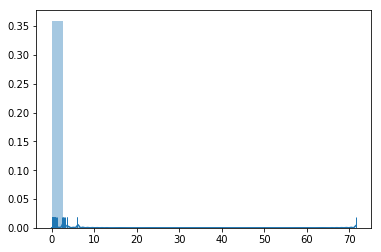

In [13]:
_, _, missing_percentages = check_for_missing(df, df_dtypes, missing_value=-7)

### Very very low "missing" percentages except for one variable with >70% missing values (which will be dropped). The rest of the variables will be coded as NaN and considered for imputation

In [14]:
df, df_dtypes, _ = check_for_missing(df, df_dtypes, missing_value=-7, make_plot=False, replace_missing=True, threshold_to_drop_perc=70)

Dropped variables:
Index(['IIIA239_summary'], dtype='object')
Percentage missing (value=-7): [71.62977867]


In [15]:
print('Final data set size (with missing values)')
print(df.shape)

Final data set size (with missing values)
(994, 708)


In [16]:
final_perc_missing = df.isnull().sum()/df.shape[0] * 100

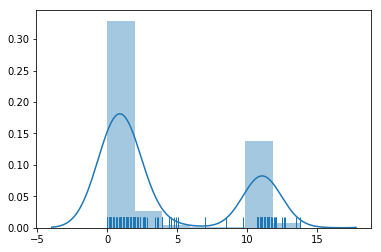

In [17]:
sns.distplot(final_perc_missing, rug=True)

### So we have variables with missing values ranging from 0 to 15% 

In [18]:
print('Variables without missing data:')
print((final_perc_missing == 0).sum())

Variables without missing data:
138


In [19]:
# Let's store everything
df['persistance_anxiety'] = y
df.to_csv('nesda_anxiety_with_missing_NaN.csv', index=False)
df_dtypes.to_csv('nesda_anxiety_data_types_with_missing_removed.csv', index=False)